<a href="https://colab.research.google.com/github/eulerianKnight/nlp_with_transformers/blob/main/text_classification_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers[torch] datasets umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
import torch.nn.functional as F

from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments

from huggingface_hub import notebook_login

In [3]:
notebook_login()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## The Data

In [5]:
# Load 'emotions' data
emotions = load_dataset('emotion')
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

### EDA for Dataset.

In [7]:
# Convert HF dataset to DataFrame for analysis.
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


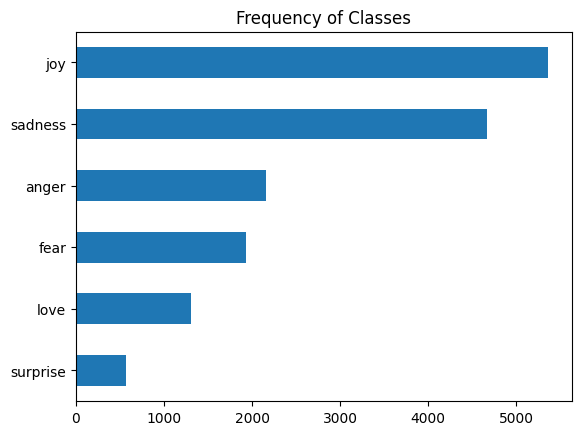

In [9]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

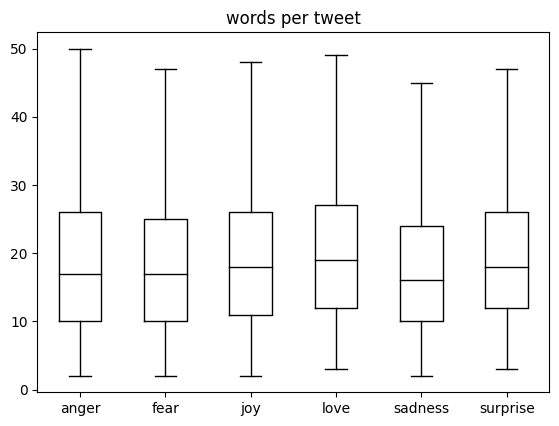

In [10]:
# Check the length of tweets
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot('words per tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

In [11]:
# Reset Dataset to HF Dataset
emotions.reset_format()

## Tokenization

In [12]:
model_ckpt = 'distilbert-base-uncased'

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
# Tokenize the whole dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [15]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [16]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Transformers as Feature Extractors

In [17]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
# Function to preprocess dataset
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return Vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [19]:
# Convert 'input_ids' and 'attention_mask' columns to 'torch' format
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [20]:
# Extract hidden states
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [21]:
# Check columns
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [22]:
# Create a Feature Matrix
x_train = np.array(emotions_hidden['train']['hidden_state'])
x_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

In [23]:
# Project the 768-dimensional Embeddings into 2D for visualization
# Scale Features to [0, 1]
X_scaled = MinMaxScaler().fit_transform(x_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# Create a DataFrame of 2D Embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.501471,6.488325,0
1,-2.839702,5.976628,0
2,5.455338,2.932592,3
3,-1.942233,3.600277,2
4,-3.047662,3.998666,3


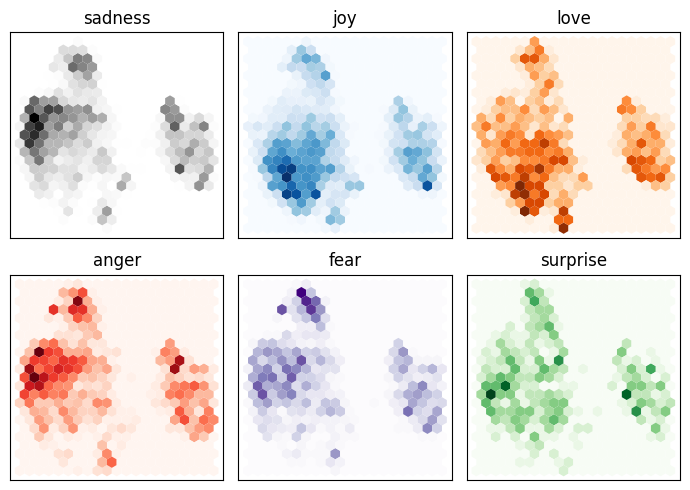

In [24]:
# Visualize the Embedding
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'],
                   df_emb_sub['Y'],
                   cmap=cmap,
                   gridsize=20,
                   linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [25]:
# Train a Classifier
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.633

In [26]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

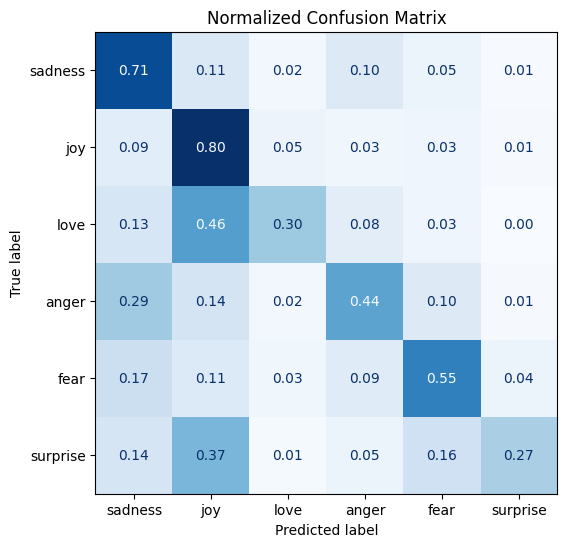

In [27]:
y_preds = lr_clf.predict(x_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

In [28]:
# Instantiate model
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.

In [29]:
# Define Performance Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [30]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error')

In [31]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/EulerianKnight/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.763600,0.251193,0.915000,0.913386
2,0.196500,0.172528,0.930000,0.930017
3,0.137500,0.147523,0.935000,0.935274
4,0.106100,0.149871,0.936000,0.935476
5,0.089200,0.142334,0.936000,0.936286


In [32]:
# Make Predictions
preds_output = trainer.predict(emotions_encoded['validation'])

In [33]:
preds_output.metrics

{'test_loss': 0.1423342078924179,
 'test_accuracy': 0.936,
 'test_f1': 0.936285614080571,
 'test_runtime': 4.1578,
 'test_samples_per_second': 481.023,
 'test_steps_per_second': 7.696}

In [34]:
y_preds = np.argmax(preds_output.predictions, axis=1)

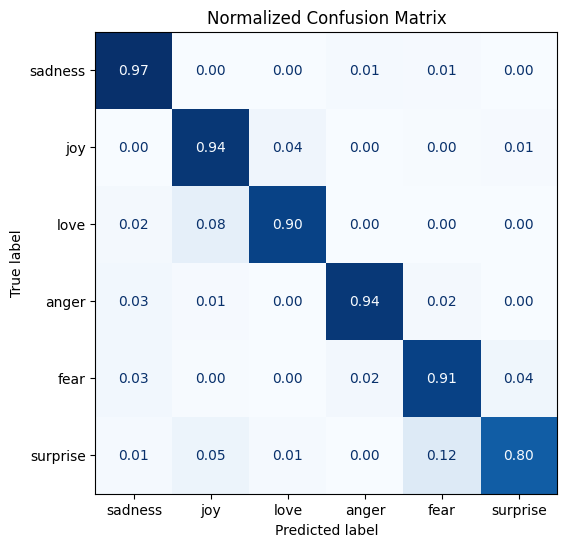

In [35]:
plot_confusion_matrix(y_preds, y_valid, labels)

## Error Analysis

In [36]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = F.cross_entropy(output.logits, batch['label'].to(device), reduction='none')
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [38]:
# Map method to dataset
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
# Compute Loss
emotions_encoded['validation'] = emotions_encoded['validation'].map(
    forward_pass_with_label,
    batched=True,
    batch_size=16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [39]:
# Create a DataFrame with texts, losses, predicted/true labels
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = (df_test['predicted_label'].apply(label_int2str))

In [40]:
# View data samples with highest loss
df_test.sort_values('loss', ascending=False).head(20)

,text,label,predicted_label,loss
1509,i guess this is a memoir so it feels like that...,joy,fear,6.678429
1111,im lazy my characters fall into categories of ...,joy,fear,6.555289
1963,i called myself pro life and voted for perry w...,joy,sadness,5.983231
882,i feel badly about reneging on my commitment t...,love,sadness,5.925592
1950,i as representative of everything thats wrong ...,surprise,sadness,5.665772
1590,deception from a person i loved very much,anger,love,5.123386
1801,i feel that he was being overshadowed by the s...,love,sadness,5.038231
188,i was going to tell you more about my trip to ...,sadness,joy,4.955618
1840,id let you kill it now but as a matter of fact...,joy,fear,4.703799
259,when i noticed two spiders running on the floo...,anger,fear,4.327648


In [41]:
# View data samples with lowest loss
df_test.sort_values('loss', ascending=True).head(20)

,text,label,predicted_label,loss
669,i am not feeling very joyful today its been a ...,joy,joy,0.001879
620,i shall move right along to the post interview...,joy,joy,0.001894
1873,i feel practically virtuous this month i have ...,joy,joy,0.001906
908,i said earlier that the overall feeling is joy...,joy,joy,0.001916
11,i was dribbling on mums coffee table looking o...,joy,joy,0.001931
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.001980
260,i am feeling so invigorated and so ready to ke...,joy,joy,0.001992
1017,i will be happy when someone i know from acros...,joy,joy,0.002007
1012,i definitely succumbed to pre holiday sales bu...,joy,joy,0.002012
1476,i finally decided that it was partially due to...,joy,joy,0.002017


In [42]:
# Commit the model
trainer.push_to_hub(commit_message='Training Completed!')

Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file runs/Jul04_19-12-50_79c81beade9e/events.out.tfevents.1688498851.79c81beade9e.250.0:   0%|         …

To https://huggingface.co/EulerianKnight/distilbert-base-uncased-finetuned-emotion
   0d8afdf..9d978d2  main -> main

   0d8afdf..9d978d2  main -> main

To https://huggingface.co/EulerianKnight/distilbert-base-uncased-finetuned-emotion
   9d978d2..2166c58  main -> main

   9d978d2..2166c58  main -> main



'https://huggingface.co/EulerianKnight/distilbert-base-uncased-finetuned-emotion/commit/9d978d23e6264e4210182c98300b071074406252'